# Using Article Embeddings to model Asset Returns: Baselines

With article embeddings at hand, we can establish some baseline results.

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(
    Path.cwd().parents[0].as_posix()
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader

from finnews.models.fc import FCBinaryClassifier
from finnews.datasets.fc import FCBinaryDataset
from finnews.models.train import train_fc_binary_classifier

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA (NVIDIA GPU)
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # MPS (Apple Silicon GPU)
else:
    device = torch.device('cpu')  # CPU

# Defines

In [3]:
root_input_dir = os.path.join("data", "processed")

train_start = "2010-01-01"
val_start = "2023-06-01"
test_start = "2023-09-01"

holding_period = 14

# Data

In [4]:
df_prices = pd.read_parquet(
    os.path.join(root_input_dir, "prices.parquet")
)

In [5]:
df_articles_meta = pd.read_parquet(
    os.path.join(root_input_dir, "articles.parquet"),
    columns=["date", "symbol", "article"]
).dropna()

df_articles_meta["date"] = pd.to_datetime(df_articles_meta["date"])

In [6]:
articles = torch.load(
    os.path.join(root_input_dir, "embeddings.pt"),
    weights_only=True,
    map_location=device
)

articles = articles[df_articles_meta.index.tolist(), :]

## Prices

Ordinary daily open and close series - will allow us to calculate returns D days after a news article was published:

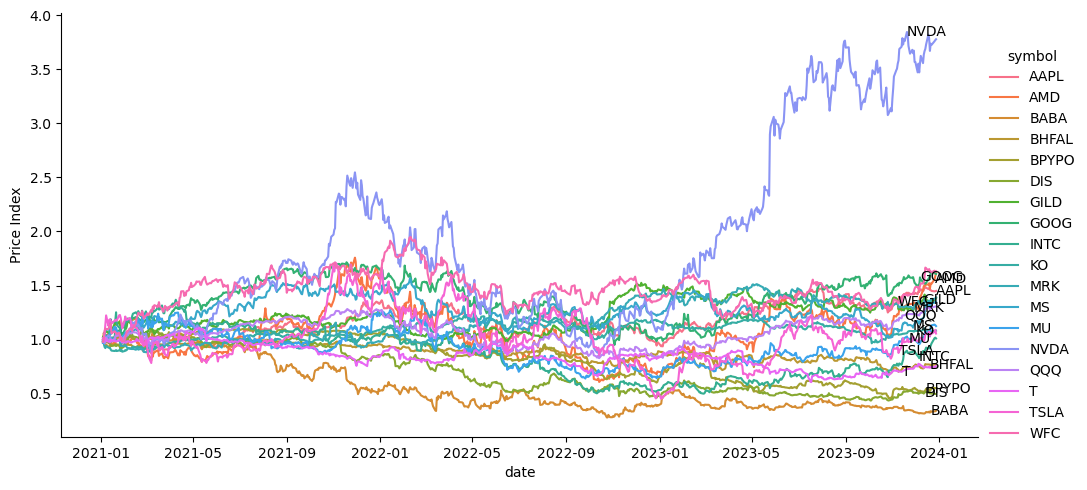

In [7]:
df_plot = df_prices.copy()
df_plot = df_plot.loc[df_plot["date"] > "2021-01-01"]
df_plot["Price Index"] = df_plot['close'] / df_plot.groupby('symbol')['open'].transform('first')

g = sns.relplot(
    kind="line",
    data=df_plot,
    x='date',
    y='Price Index',
    hue='symbol',
    aspect=2,
)

ax = g.axes[0, 0]  # get the single axis (assuming there's just one subplot)
i = 0
for symbol, grp in df_plot.groupby('symbol'):
    # Last point
    x_val = grp['date'].iloc[-1 - i]
    y_val = grp['Price Index'].iloc[-1 - i]

    ax.text(
        x_val,
        y_val,
        symbol,
        va='center',
        ha='left',
        fontsize=10
    )
    i = i + 2

## Articles

There can be multiple articles mentioning a single company on a given day. As a first approximation, we'll average article embeddings:

In [8]:
df_articles_meta_agg = df_articles_meta.groupby(
    ["date", "symbol"]
).apply(
    lambda x: x.index.tolist(), 
    include_groups=False
).to_frame(
    "indices"
).reset_index()

df_articles_meta_agg = df_articles_meta_agg.sort_values(
    ["symbol", "date"],
    ignore_index=True
)

In [9]:
articles_agg = torch.stack(
    [
        articles[x].mean(axis=0)
        for x in df_articles_meta_agg["indices"].tolist()
    ],
    axis=0
)

## Targets: Price Returns

- Articles are published on day $t$
- Stock is bought at the open of $t+1$, and sold at $t+15$ (14 day holding period)

In [10]:
# Create a complete date range for each symbol
all_dates = pd.date_range(start=df_prices['date'].min(), end=df_prices['date'].max())
all_symbols = df_prices['symbol'].unique()

# Create a multi-index with every combination of symbol and date
multi_index = pd.MultiIndex.from_product([all_symbols, all_dates], names=['symbol', 'date'])

# Reindex the DataFrame
df_prices_ext = df_prices.set_index(['symbol', 'date'])
df_prices_ext = df_prices_ext.reindex(multi_index)

# Backfill NaN values in 'open' and 'close' columns
df_prices_ext = df_prices_ext.sort_index(level=["symbol", "date"])  # Ensure dates are sorted for backfilling
df_prices_ext[['open', 'close']] = df_prices_ext.groupby('symbol')[['open', 'close']].bfill()

In [11]:
df_prices_ext["ret"] = df_prices_ext.groupby(
    'symbol'
).apply(
    lambda x: (x["close"].shift(-(holding_period + 1)) - x["open"].shift(-1))
).reset_index(level=0, drop=True)

In [12]:
df_articles_meta_agg = pd.merge(
    df_articles_meta_agg,
    df_prices_ext["ret"],
    how="left",
    left_on=["symbol", "date"],
    right_index=True
)

In [13]:
df_articles_meta_agg = df_articles_meta_agg.dropna()

In [14]:
df_articles_meta_agg["y"] = (df_articles_meta_agg["ret"] > 0).astype(int)

In [15]:
tsne = TSNE(n_components=2, random_state=42)
articles_agg_tsne = tsne.fit_transform(
    articles_agg.cpu().numpy()
)

In [16]:
df_tsne = pd.DataFrame(articles_agg_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne = df_tsne.loc[df_articles_meta_agg.index]
df_tsne[['symbol', 'y']] = df_articles_meta_agg[['symbol', 'y']]

On their own, embeddings say more about companies, rather than their near-term returns:

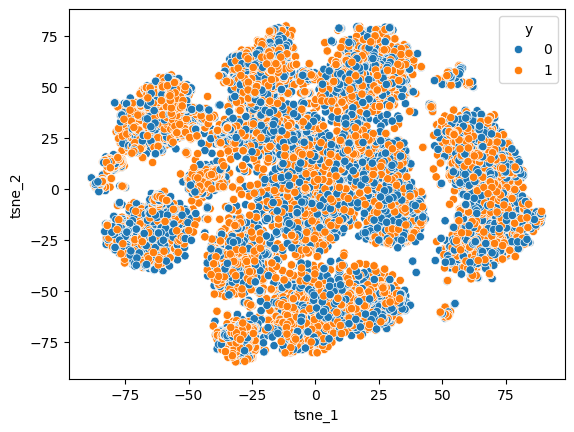

In [17]:
sns.scatterplot(data=df_tsne, x='tsne_1', y='tsne_2', hue='y')
plt.show()

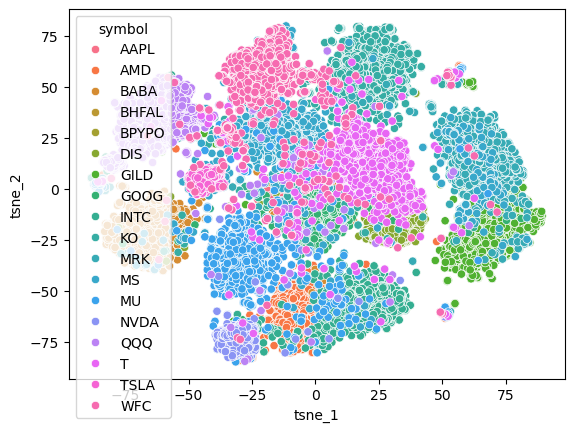

In [18]:
sns.scatterplot(data=df_tsne, x='tsne_1', y='tsne_2', hue='symbol')
plt.show()

## Train / Val / Test Split

- Very ordinary time-based split without overlaps
- **Hypothesis**: how would we perform on any given day as opposed to as an overall strategy

In [19]:
train_idx = df_articles_meta_agg.loc[
    df_articles_meta_agg["date"] < pd.to_datetime(val_start) - pd.Timedelta(f'{holding_period}d')
].index

val_idx = df_articles_meta_agg.loc[
    (df_articles_meta_agg["date"] >= pd.to_datetime(val_start))
    & (df_articles_meta_agg["date"] < pd.to_datetime(test_start) - pd.Timedelta(f'{holding_period}d'))
].index

test_idx = df_articles_meta_agg.loc[
    (df_articles_meta_agg["date"] >= pd.to_datetime(test_start))
].index

In [20]:
[len(x) for x in [train_idx, val_idx, test_idx]]

[28524, 1132, 1470]

In [21]:
ds_train = FCBinaryDataset(
    x=articles_agg[list(train_idx), :], 
    y=torch.tensor(
        df_articles_meta_agg.loc[train_idx, "y"].values,
        dtype=torch.int64
    )
)

ds_val = FCBinaryDataset(
    x=articles_agg[list(val_idx), :], 
    y=torch.tensor(
        df_articles_meta_agg.loc[val_idx, "y"].values,
        dtype=torch.int64
    )
)

ds_test = FCBinaryDataset(
    x=articles_agg[list(test_idx), :], 
    y=torch.tensor(
        df_articles_meta_agg.loc[test_idx, "y"].values,
        dtype=torch.int64
    )
)

# Simple Logistic Regression

Using daily averages of article embeddings to forecast the sign of returns over the next 14 days.

A simple FC network acting as a baseline

In [22]:
batch_size = 64

input_dim = articles_agg.shape[-1]
hidden_dims = [128, 64, 32, 16]
learning_rate = 1e-3
    
cur_timestamp = pd.Timestamp.now().strftime('%d_%m_%Y_%H_%M_%S')
model_save_dir = os.path.join(
    "models",
    "FCBinaryClassifier",
    cur_timestamp
)
os.makedirs(model_save_dir, exist_ok=True)

In [23]:
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [24]:
model = FCBinaryClassifier(
    input_dim=input_dim, 
    hidden_dims=hidden_dims, 
    dropout_rate=0.15
)

In [25]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate
)

## Train

In [26]:
epochs = 100
patience = 25

In [27]:
train_fc_binary_classifier(
    model=model,
    dataloader_train=dl_train,
    dataloader_val=dl_val,
    optimizer=optimizer,
    save_dir=model_save_dir,
    epochs=epochs,
    device=device,
    patience=patience
)

Epoch [1/100], Train Loss: 0.6901, Val Loss: 0.6930, Precision: 0.5081, Recall: 0.9246, F1: 0.6558, ROC AUC: 0.5494
Epoch [2/100], Train Loss: 0.6873, Val Loss: 0.7007, Precision: 0.4867, Recall: 0.9743, F1: 0.6491, ROC AUC: 0.5605
Epoch [3/100], Train Loss: 0.6857, Val Loss: 0.6950, Precision: 0.5010, Recall: 0.8897, F1: 0.6411, ROC AUC: 0.5589
Epoch [4/100], Train Loss: 0.6850, Val Loss: 0.6916, Precision: 0.5107, Recall: 0.8346, F1: 0.6336, ROC AUC: 0.5593
Epoch [5/100], Train Loss: 0.6840, Val Loss: 0.7011, Precision: 0.4980, Recall: 0.9246, F1: 0.6474, ROC AUC: 0.5606
Epoch [6/100], Train Loss: 0.6830, Val Loss: 0.7034, Precision: 0.4939, Recall: 0.9596, F1: 0.6521, ROC AUC: 0.5503
Epoch [7/100], Train Loss: 0.6824, Val Loss: 0.6966, Precision: 0.4974, Recall: 0.8934, F1: 0.6391, ROC AUC: 0.5559
Epoch [8/100], Train Loss: 0.6813, Val Loss: 0.6932, Precision: 0.5143, Recall: 0.6949, F1: 0.5911, ROC AUC: 0.5518
Epoch [9/100], Train Loss: 0.6802, Val Loss: 0.6913, Precision: 0.4922, 

## Test Dataset

Performance on test set per asset. Using validation set to get individual probability cut-offs.

We won't be starting a new systematic hedge fund with this model, however it's a good start given its simplicity.

In [28]:
df_val = df_articles_meta_agg.loc[val_idx].copy()
df_test = df_articles_meta_agg.loc[test_idx].copy()

In [29]:
chkpoint = torch.load(
    os.path.join(model_save_dir, "best_model.pt"), 
    map_location=device,
    weights_only=False
)

model_dict = model.state_dict()

model_dict.update(chkpoint)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [30]:
# Validation dataset
y_pred_val = []

for cur_x, _ in dl_val:
    cur_x = cur_x.to(device)
    cur_y = model(cur_x)
    
    y_pred_val.extend(cur_y.detach().cpu().numpy())

In [31]:
# Test dataset
y_pred_test = []

for cur_x, _ in dl_test:
    cur_x = cur_x.to(device)
    cur_y = model(cur_x)
    
    y_pred_test.extend(cur_y.detach().cpu().numpy())

In [32]:
df_val["y_pred_prob"] = np.array(y_pred_val)
df_test["y_pred_prob"] = np.array(y_pred_test)

In [33]:
optimal_thresholds = {}

for symbol, group in df_val.groupby("symbol"):
    best_threshold = 0.0
    best_auc = 0.0

    for threshold in np.linspace(0, 1, 101):
        preds = (group["y_pred_prob"] >= threshold).astype(int)
        auc = roc_auc_score(group["y"], preds)

        if auc > best_auc:
            best_auc = auc
            best_threshold = threshold

    optimal_thresholds[symbol] = best_threshold

In [34]:
df_optimal_thresholds = pd.DataFrame.from_dict(
    optimal_thresholds | {'BHFAL': 0.5, 'BPYPO': 0.5}, 
    orient="index", 
    columns=["optimal_threshold"]
).rename_axis("symbol")

In [35]:
df_test["prob_threshold"] = df_optimal_thresholds.loc[df_test["symbol"], "optimal_threshold"].values
df_test["y_pred"] = (df_test["y_pred_prob"] > df_test["prob_threshold"]).astype(int)
df_test["match"] = (df_test["y"] == df_test["y_pred"])

In [36]:
print(f"Overall Model Accuracy: {df_test["match"].mean()}")

Overall Model Accuracy: 0.5102040816326531


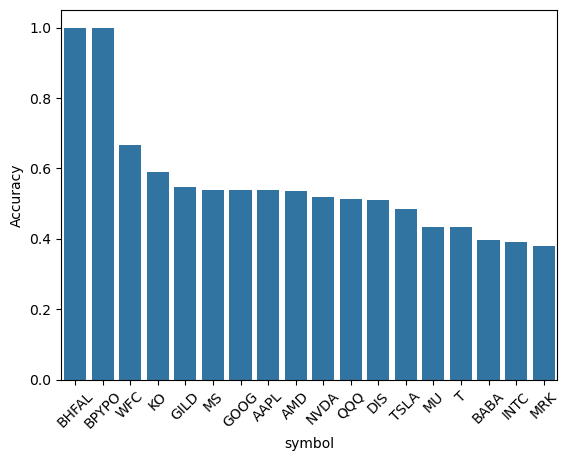

In [37]:
df_plot = df_test.groupby("symbol")["match"].agg(
    ["count", "mean"]
).rename(columns={"mean": "Accuracy"}).sort_values(
    by="Accuracy", ascending=False
)

sns.barplot(
    data=df_plot.reset_index(),
    x="symbol",
    y="Accuracy",
    order=df_plot.index,
)
plt.xticks(rotation=45)
plt.show()

In [38]:
summary_table = {
    "Metric": ["Precision", "Recall", "F1 Score", "ROC AUC"],
    "Overall": [
        precision_score(df_test["y"], df_test["y_pred"], zero_division=np.nan),
        recall_score(df_test["y"], df_test["y_pred"]),
        f1_score(df_test["y"], df_test["y_pred"]),
        roc_auc_score(df_test["y"], df_test["y_pred_prob"])
    ]
}

for symbol, group in df_test.groupby("symbol"):
    try:
        cur_roc_auc = roc_auc_score(group["y"], group["y_pred_prob"])
    except:
        cur_roc_auc = None
    
    summary_table[symbol] = [
        precision_score(group["y"], group["y_pred"], zero_division=np.nan),
        recall_score(group["y"], group["y_pred"]),
        f1_score(group["y"], group["y_pred"]),
        cur_roc_auc
    ]

df_summary = pd.DataFrame(summary_table)

In [39]:
df_summary

,Metric,Overall,AAPL,AMD,BABA,BHFAL,BPYPO,DIS,GILD,GOOG,INTC,KO,MRK,MS,MU,NVDA,QQQ,T,TSLA,WFC
0,Precision,0.593325,0.606061,0.800000,0.314286,1.0,1.0,0.552239,0.666667,0.538462,0.600000,0.617647,0.325000,0.818182,0.681818,0.519231,0.760000,0.724138,0.666667,0.728814
1,Recall,0.551091,0.645161,0.417910,0.916667,1.0,1.0,0.649123,0.242424,1.000000,0.145161,0.736842,0.351351,0.214286,0.272727,1.000000,0.380000,0.328125,0.507042,0.826923
2,F1 Score,0.571429,0.625000,0.549020,0.468085,1.0,1.0,0.596774,0.355556,0.700000,0.233766,0.672000,0.337662,0.339623,0.389610,0.683544,0.506667,0.451613,0.576000,0.774775
3,ROC AUC,0.509456,0.529570,0.588619,0.529661,NaN,NaN,0.448343,0.500489,0.554315,0.540092,0.581803,0.408408,0.528711,0.575325,0.522222,0.630000,0.519832,0.445423,0.390468
